<a href="https://colab.research.google.com/github/StefanFischer/Tutorials/blob/main/Tutorial_on_Foundation_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toturial on Foundation Models

Goal of this tutorial:


*   Learn how to apply SAM Model and Universeg Model on medical data
*   Compare those models on two/three tasks
(Lung tumor segmentation, Brain tumor segmentation,

> 1. Lung Tumor Segmentation on NSCLC Radiogenomics

> 2. Brain Tumor Segmentation on BRATS

*   Get some insights about those models and their usecases

## Segment Anything Model

Published by Facebook in the paper 'Segment Anything' (April 2023): https://arxiv.org/pdf/2304.02643.pdf

Model:


*   Promptable Model: Text Prompt, Point Prompt, Bounding Box Prompt
*   Zero-shot Model: No training data needed
*   Trained on 11 million natural images with over 1 billion masks
*   2D model
*   Three possible scenarios:

> 1. Fully automatic segmentation of image into subregions: This does not offer any (semantic) information about those segmented regions. Therefore, it needs postprocessing if you want to get a semantic segmentation. The segmentation is generated by using the point prompt. A equally spaced grid with points will be given as an input to the point prompt.

> 2. Fully automatic via text prompt: If you know what should be segmented you can give this as a text input.

> 3. Semi-automatic via point/bounding box prompt: This can help with annotating data


![SAM Architecture](/content/drive/MyDrive/Tutorials/sam_architecture.png)


## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.



In [1]:
!nvidia-smi

Thu Jul 13 11:32:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [3]:
!pip install -q jupyter_bbox_widget supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 76.6 MB/s eta 0:00:00


## Install Segment Anything Model (SAM) and other dependencies


In [4]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-9hjq9bsp
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-9hjq9bsp
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=882df6a6c58904d721f1f85cd77eee073032609c82295acbbff9c0c2568f3813
  Stored in directory: /tmp/pip-ephem-wheel-cache-nofrbxrf/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


### Download SAM weights

In [5]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [6]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


## Load Model

In [7]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [8]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

## Load Data: NSCLC data

We already prepared a Google Folder with 2D slices of the datasets. Lets load some samples of the NSCLC dataset

In [9]:
import supervision as sv
import cv2
import glob
import numpy as np

In [10]:
ct_files = glob.glob("/content/drive/MyDrive/Tutorials/NSCLC/imagesTr/*.npy")[0:5]
seg_files = [x.replace('imagesTr', 'labelsTr').replace("_0000","") for x in ct_files]
print(ct_files)
ct_imgs = [np.load(x) for x in ct_files]
seg_imgs = [np.load(x) for x in seg_files]


['/content/drive/MyDrive/Tutorials/NSCLC/imagesTr/R01-068_0000.npy', '/content/drive/MyDrive/Tutorials/NSCLC/imagesTr/R01-101_0000.npy', '/content/drive/MyDrive/Tutorials/NSCLC/imagesTr/R01-097_0000.npy', '/content/drive/MyDrive/Tutorials/NSCLC/imagesTr/R01-075_0000.npy', '/content/drive/MyDrive/Tutorials/NSCLC/imagesTr/R01-008_0000.npy']


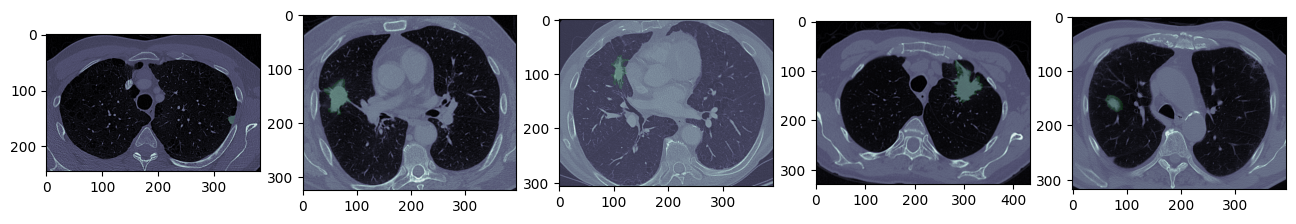

In [11]:
from matplotlib.colors import ListedColormap
from matplotlib.colors import to_rgba
import matplotlib.pyplot as plt

def plot_images_with_annotations(imgs, segs):
  green_cmap = [[1.0, 1.0, 1.0 ,0]]
  green_cmap.append(to_rgba('lime'))
  green_cmap = ListedColormap(green_cmap)

  fig, ax = plt.subplots(1, len(imgs), figsize=(16, 16))
  for idx in range(len(imgs)):
    ax[idx].imshow(imgs[idx], cmap='bone')
    ax[idx].imshow(segs[idx], cmap=green_cmap, alpha=0.1)
  plt.show()

plot_images_with_annotations(ct_imgs, seg_imgs)

## Automated Mask Generation: NSCLC data



To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [12]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [13]:
def convert_from_grey_to_rgb_img(grey_img):
  """
  Convert grey scale image to RGB image, as SAM only works on RGB images.
  Therefore just copy grey image to all three channels
  and do min-max normalization between 0-255
  """

  print(grey_img.shape)
  rgb_img = np.dstack((grey_img, grey_img, grey_img))
  rgb_img = ((rgb_img/np.max(rgb_img))*255).astype(np.uint8)
  print(rgb_img.shape)
  return rgb_img

from tqdm import tqdm

sam_results = []
rgb_imgs = []
for ct_img in tqdm(ct_imgs):
  rgb_img = convert_from_grey_to_rgb_img(ct_img)
  sam_result = mask_generator.generate(rgb_img)
  rgb_imgs.append(rgb_img)
  sam_results.append(sam_result)

  0%|          | 0/5 [00:00<?, ?it/s]

(244, 382)
(244, 382, 3)


 20%|██        | 1/5 [00:14<00:59, 14.86s/it]

(325, 396)
(325, 396, 3)


 40%|████      | 2/5 [00:20<00:27,  9.29s/it]

(306, 393)
(306, 393, 3)


 60%|██████    | 3/5 [00:25<00:15,  7.51s/it]

(329, 433)
(329, 433, 3)


 80%|████████  | 4/5 [00:31<00:06,  6.93s/it]

(317, 394)
(317, 394, 3)


100%|██████████| 5/5 [00:37<00:00,  7.51s/it]


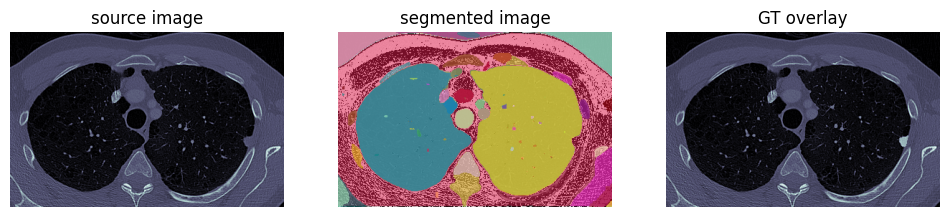

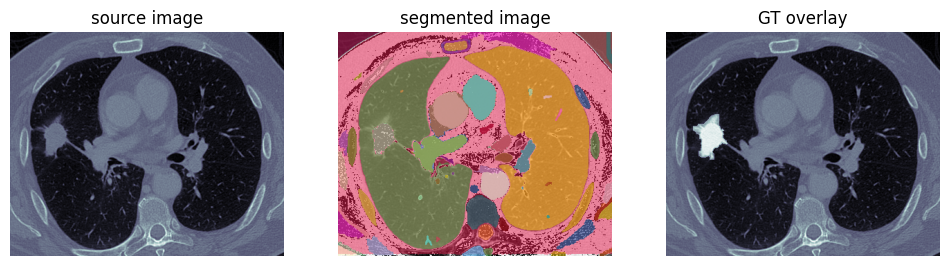

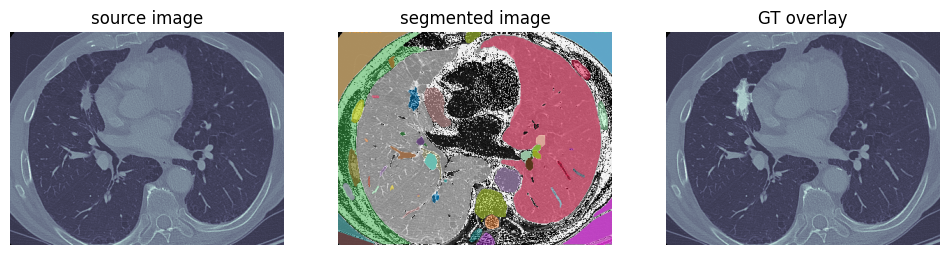

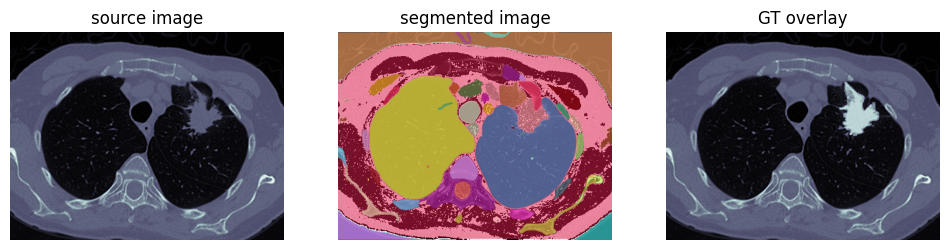

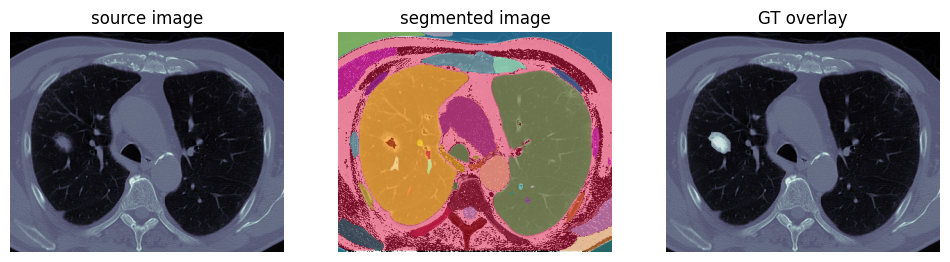

In [14]:
for idx in range(len(sam_results)):
  mask_annotator = sv.MaskAnnotator()

  detections = sv.Detections.from_sam(sam_result=sam_results[idx])

  annotated_image = mask_annotator.annotate(scene=rgb_imgs[idx].copy(), detections=detections)

  overlay = ct_imgs[idx]
  overlay = overlay + 1000*seg_imgs[idx]


  sv.plot_images_grid(
      images=[ct_imgs[idx], annotated_image, overlay],
      grid_size=(1, 3),
      titles=['source image', 'segmented image', 'GT overlay'],
      cmap="bone")


## Load Data: Sarcoma data

We already prepared a Google Folder with 2D slices of the datasets. Lets load some samples of the Sarcoma dataset

In [15]:
mr_files = glob.glob("/content/drive/MyDrive/Tutorials/Sarcoma/imagesTr/*.npy")
seg_files = [x.replace('imagesTr', 'labelsTr').replace("_0000","") for x in mr_files]
print(mr_files)
mr_imgs = [np.load(x) for x in mr_files]
seg_imgs = [np.load(x) for x in seg_files]


['/content/drive/MyDrive/Tutorials/Sarcoma/imagesTr/STS_050_0000.npy', '/content/drive/MyDrive/Tutorials/Sarcoma/imagesTr/STS_005_0000.npy', '/content/drive/MyDrive/Tutorials/Sarcoma/imagesTr/STS_047_0000.npy', '/content/drive/MyDrive/Tutorials/Sarcoma/imagesTr/STS_044_0000.npy', '/content/drive/MyDrive/Tutorials/Sarcoma/imagesTr/STS_027_0000.npy', '/content/drive/MyDrive/Tutorials/Sarcoma/imagesTr/STS_028_0000.npy', '/content/drive/MyDrive/Tutorials/Sarcoma/imagesTr/STS_038_0000.npy', '/content/drive/MyDrive/Tutorials/Sarcoma/imagesTr/STS_022_0000.npy', '/content/drive/MyDrive/Tutorials/Sarcoma/imagesTr/STS_034_0000.npy', '/content/drive/MyDrive/Tutorials/Sarcoma/imagesTr/STS_024_0000.npy', '/content/drive/MyDrive/Tutorials/Sarcoma/imagesTr/STS_049_0000.npy', '/content/drive/MyDrive/Tutorials/Sarcoma/imagesTr/STS_010_0000.npy', '/content/drive/MyDrive/Tutorials/Sarcoma/imagesTr/STS_032_0000.npy', '/content/drive/MyDrive/Tutorials/Sarcoma/imagesTr/STS_031_0000.npy', '/content/drive/MyD

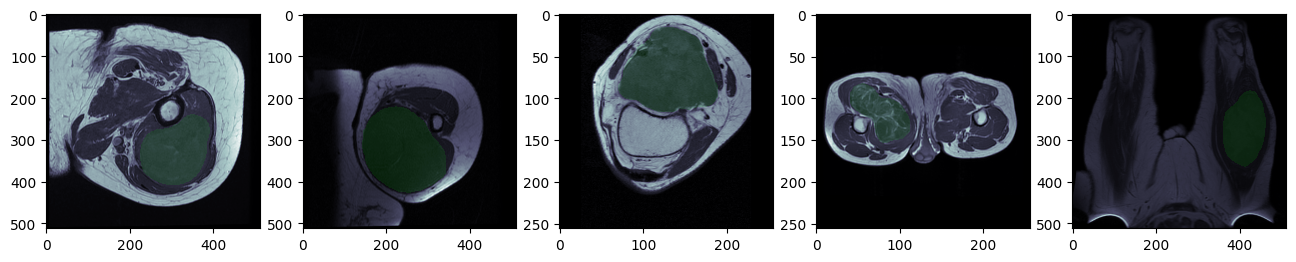

In [16]:
from matplotlib.colors import ListedColormap
from matplotlib.colors import to_rgba
import matplotlib.pyplot as plt

plot_images_with_annotations(mr_imgs[:5], seg_imgs[:5])

## Automated Mask Generation: Sarcoma data



In [17]:
sam_results = []
rgb_imgs = []
for mr_img in tqdm(mr_imgs[0:5]):
  rgb_img = convert_from_grey_to_rgb_img(mr_img)
  sam_result = mask_generator.generate(rgb_img)
  rgb_imgs.append(rgb_img)
  sam_results.append(sam_result)

  0%|          | 0/5 [00:00<?, ?it/s]

(512, 512)
(512, 512, 3)


 20%|██        | 1/5 [00:05<00:22,  5.65s/it]

(512, 512)
(512, 512, 3)


 40%|████      | 2/5 [00:11<00:16,  5.56s/it]

(256, 256)
(256, 256, 3)


 60%|██████    | 3/5 [00:16<00:11,  5.64s/it]

(256, 256)
(256, 256, 3)


 80%|████████  | 4/5 [00:22<00:05,  5.66s/it]

(512, 512)
(512, 512, 3)


100%|██████████| 5/5 [00:28<00:00,  5.66s/it]


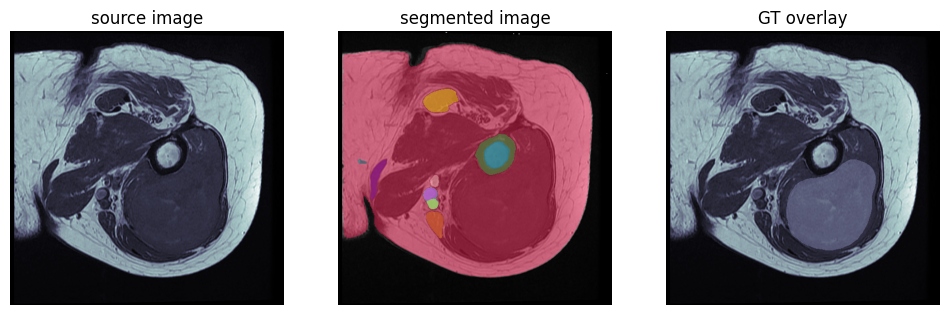

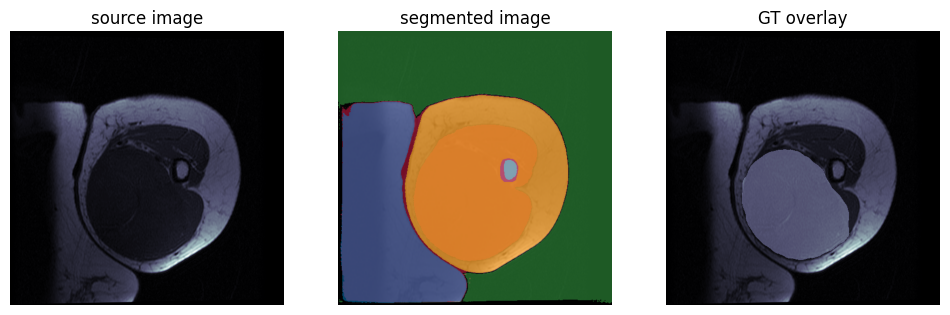

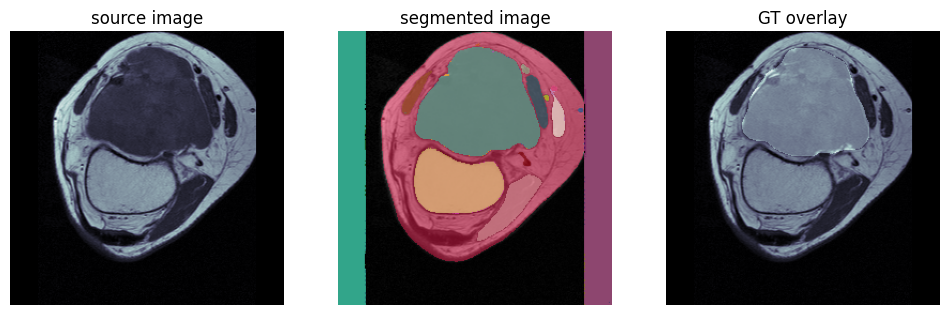

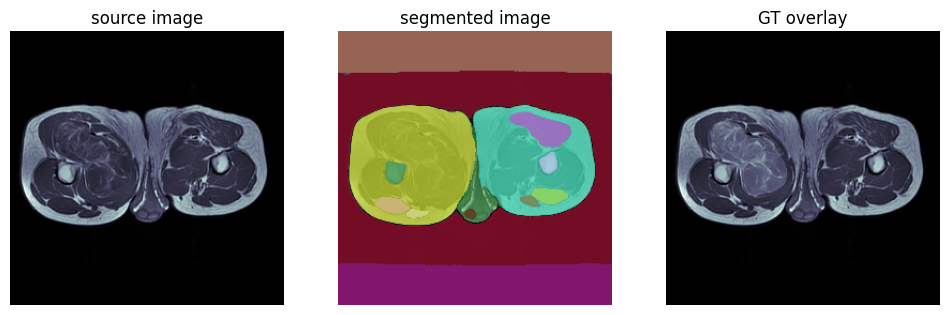

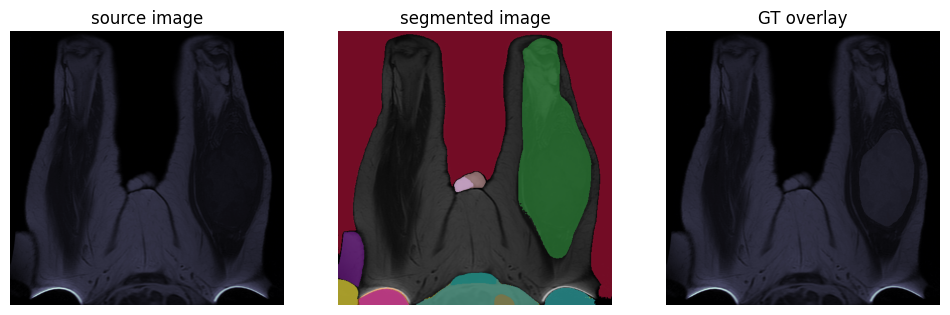

In [18]:
for idx in range(0, 5):
  mask_annotator = sv.MaskAnnotator()

  detections = sv.Detections.from_sam(sam_result=sam_results[idx])

  annotated_image = mask_annotator.annotate(scene=rgb_imgs[idx].copy(), detections=detections)

  overlay = mr_imgs[idx]
  overlay = overlay + 10*seg_imgs[idx]


  sv.plot_images_grid(
      images=[mr_imgs[idx], annotated_image, overlay],
      grid_size=(1, 3),
      titles=['source image', 'segmented image', 'GT overlay'],
      cmap="bone"
  )

## Load Data: BRATS data

We already prepared a Google Folder with 2D slices of the datasets. Lets load some samples of the BRATS dataset

In [19]:
mr_files = glob.glob("/content/drive/MyDrive/Tutorials/BRATS-T1-ce/imagesTr/*.npy")[0:200]
seg_files = [x.replace('imagesTr', 'labelsTr').replace("_0000","") for x in mr_files]
print(mr_files)
mr_imgs = [np.load(x) for x in mr_files]
seg_imgs = [np.load(x) for x in seg_files]


['/content/drive/MyDrive/Tutorials/BRATS-T1-ce/imagesTr/subject_002_0000.npy', '/content/drive/MyDrive/Tutorials/BRATS-T1-ce/imagesTr/subject_001_0000.npy', '/content/drive/MyDrive/Tutorials/BRATS-T1-ce/imagesTr/subject_003_0000.npy', '/content/drive/MyDrive/Tutorials/BRATS-T1-ce/imagesTr/subject_004_0000.npy', '/content/drive/MyDrive/Tutorials/BRATS-T1-ce/imagesTr/subject_005_0000.npy', '/content/drive/MyDrive/Tutorials/BRATS-T1-ce/imagesTr/subject_006_0000.npy', '/content/drive/MyDrive/Tutorials/BRATS-T1-ce/imagesTr/subject_007_0000.npy', '/content/drive/MyDrive/Tutorials/BRATS-T1-ce/imagesTr/subject_009_0000.npy', '/content/drive/MyDrive/Tutorials/BRATS-T1-ce/imagesTr/subject_008_0000.npy', '/content/drive/MyDrive/Tutorials/BRATS-T1-ce/imagesTr/subject_010_0000.npy', '/content/drive/MyDrive/Tutorials/BRATS-T1-ce/imagesTr/subject_011_0000.npy', '/content/drive/MyDrive/Tutorials/BRATS-T1-ce/imagesTr/subject_012_0000.npy', '/content/drive/MyDrive/Tutorials/BRATS-T1-ce/imagesTr/subject_

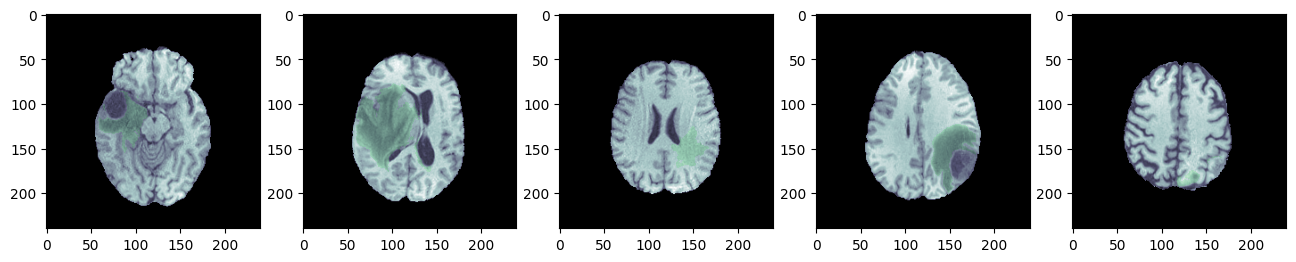

In [20]:
from matplotlib.colors import ListedColormap
from matplotlib.colors import to_rgba
import matplotlib.pyplot as plt

plot_images_with_annotations(mr_imgs[:5], seg_imgs[:5])

## Automated Mask Generation: BRATS data



In [21]:
sam_results = []
rgb_imgs = []
for mr_img in tqdm(mr_imgs[0:5]):
  rgb_img = convert_from_grey_to_rgb_img(mr_img)
  sam_result = mask_generator.generate(rgb_img)
  rgb_imgs.append(rgb_img)
  sam_results.append(sam_result)

  0%|          | 0/5 [00:00<?, ?it/s]

(240, 240)
(240, 240, 3)


 20%|██        | 1/5 [00:05<00:23,  5.91s/it]

(240, 240)
(240, 240, 3)


 40%|████      | 2/5 [00:11<00:17,  5.72s/it]

(240, 240)
(240, 240, 3)


 60%|██████    | 3/5 [00:16<00:11,  5.56s/it]

(240, 240)
(240, 240, 3)


 80%|████████  | 4/5 [00:22<00:05,  5.48s/it]

(240, 240)
(240, 240, 3)


100%|██████████| 5/5 [00:28<00:00,  5.63s/it]


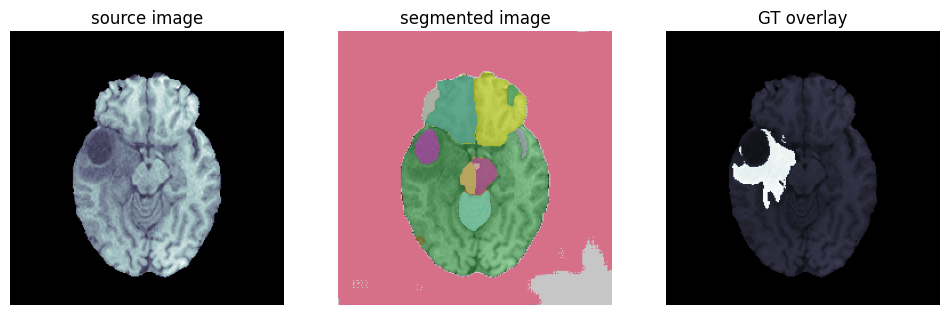

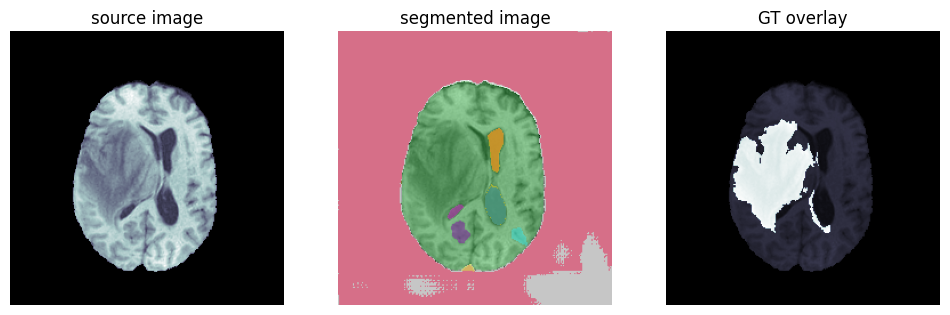

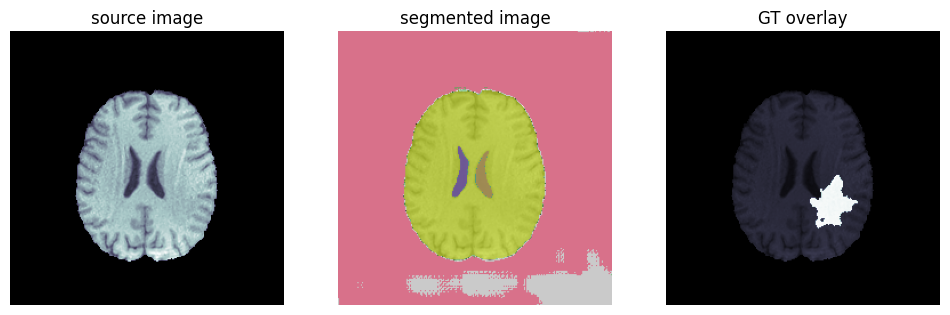

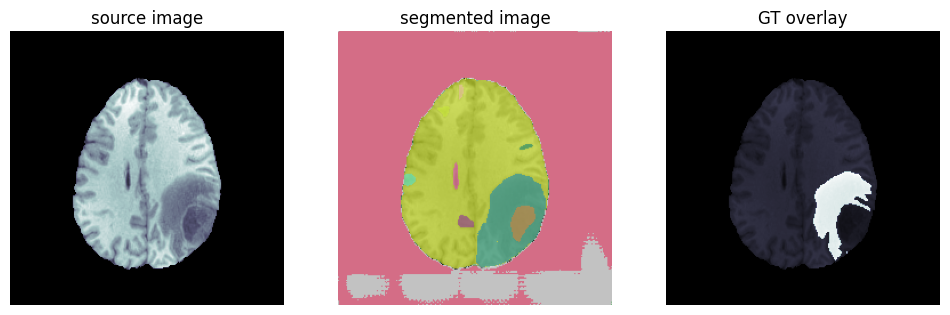

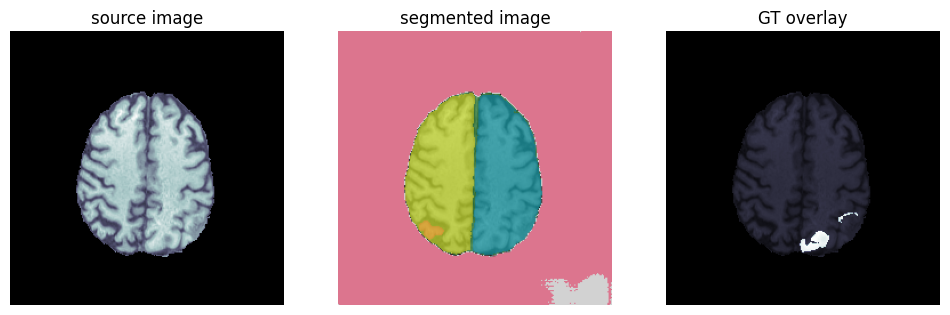

In [22]:
for idx in range(0, len(sam_results)):
  mask_annotator = sv.MaskAnnotator()

  detections = sv.Detections.from_sam(sam_result=sam_results[idx])

  annotated_image = mask_annotator.annotate(scene=rgb_imgs[idx].copy(), detections=detections)

  overlay = mr_imgs[idx]
  overlay = overlay + 10*seg_imgs[idx]


  sv.plot_images_grid(
      images=[mr_imgs[idx], annotated_image, overlay],
      grid_size=(1, 3),
      titles=['source image', 'segmented image', 'GT overlay'],
      cmap="bone"
  )

## Postprocessing

Now we have segments of the images. To get a semantic segmentation output we would need to postprocess this labelmap. This would be a non-trivial step. We therefore cannot use this to fully automatically segment any structure...

## Use SAM with Text Prompt

The text prompt can also be seen as an automtic segmentation pipeline, as the semantic information can be given in text form.
**BUT the text prompt version of SAM is not yet released!**

## Use SAM as semi-automatic annotation tool

To train deep learning networks we need to have large amounts of annotated data. In the medical domain of 3D images, this makes data very expensive, as they also need to be labeled by an medical expert. If the task is then also segmentation, the cost of annotating on a voxel base is tremendous. Therefore, different tools are used to automate the process of annotating data.

For this Watershed, Otsu, Level tracing and Clustering can be used. Deep learning based interactive segmentation tools are now also an alternative. SAM was integrated into the GUI of 3D Slicer, a widely used medical imaging toolbox for 3D data (https://github.com/fsemerar/SlicerTomoSAM).

The biggest drawback for SAM in the domain of medical imaging is that it can only process 2D data and was trained on natural images and not medical images, which is a big domain shift.




# Comparing SAM with supervised methods

In the paper "Computer-Vision Benchmark Segment-Anything
Model (SAM) in Medical Images: Accuracy in 12 Datasets" of He et al. the performance of SAM in the medical imaging domain was evaluated in 12 different tasks.

Here is the performance comparison with sota supervised methods.

"When multiple masks were obtained for different regions/structures in the image, we chose the mask with the highest overlap with the ground-truth mask and used it as the segmentation. SAM-Point (single-point prompt setting): we used the mass center of the ground-truth mask as the point prompt. SAM-Box (bounding-box prompt setting): we computed the bounding box for SAM around the ground-truth mask with a dilation of 20 pixels."


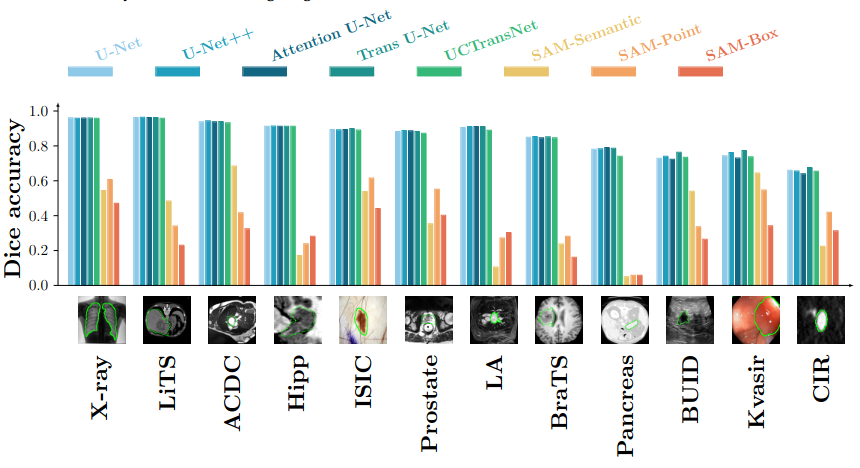

# Universeg Model

A few-shot segmentation model for medical image segmentation published in paper 'UniverSeg: Universal Medical Image Segmentation' from MIT.

Model:
*   Based on a task prompt that learns task on the fly during inference via support set
*   Few-shot Model: small number of annotated examples are needed, namely the support set (authors suggest 64 image-annotation pairs)
*   trained on 53 datasets over 26 medical domains, 16 imaging modalities, with >22,000 scans
*   2D model


In [23]:
!git clone https://github.com/JJGO/UniverSeg
!python -m pip install -r ./UniverSeg/requirements.txt

Cloning into 'UniverSeg'...
remote: Enumerating objects: 224, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 224 (delta 1), reused 2 (delta 0), pack-reused 216
Receiving objects: 100% (224/224), 35.26 MiB | 16.78 MiB/s, done.
Resolving deltas: 100% (97/97), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.0 MB/s eta 0:00:00


In [24]:
import math
import itertools

from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

import einops as E

In [25]:
import sys
sys.path.append('UniverSeg')

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from universeg import universeg
model = universeg(pretrained=True)
model = model.to(device)

Downloading: "https://github.com/JJGO/UniverSeg/releases/download/weights/universeg_v1_nf64_ss64_STA.pt" to /root/.cache/torch/hub/checkpoints/universeg_v1_nf64_ss64_STA.pt
100%|██████████| 4.53M/4.53M [00:00<00:00, 16.4MB/s]


In [26]:
def visualize_tensors(tensors, col_wrap=8, col_names=None, title=None):
    M = len(tensors)
    N = len(next(iter(tensors.values())))

    cols = col_wrap
    rows = math.ceil(N/cols) * M

    d = 2.5
    fig, axes = plt.subplots(rows, cols, figsize=(d*cols, d*rows))
    if rows == 1:
      axes = axes.reshape(1, cols)

    for g, (grp, tensors) in enumerate(tensors.items()):
        for k, tensor in enumerate(tensors):
            col = k % cols
            row = g + M*(k//cols)
            x = tensor.detach().cpu().numpy().squeeze()
            ax = axes[row,col]
            if len(x.shape) == 2:
                ax.imshow(x,vmin=0, vmax=1, cmap='gray')
            else:
                ax.imshow(E.rearrange(x,'C H W -> H W C'))
            if col == 0:
                ax.set_ylabel(grp, fontsize=16)
            if col_names is not None and row == 0:
                ax.set_title(col_names[col])

    for i in range(rows):
        for j in range(cols):
            ax = axes[i,j]
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])

    if title:
        plt.suptitle(title, fontsize=20)

    plt.tight_layout()


## 2. Inference on unseen segmentation task

In this section we will show how a global universeg can segment images from a new segmentation task -- in a completely unseen domain

Given a new segmentation task (e.g. new biomedical domain, new image type, new region of interest, etc), most existing strategies involve training or fine-tuning a segmentation model (often a UNet-like CNN) that takes as input an image $x$ and outputs the segmentation map $y$.

This process works well in machine-learning labs, but is challenging in many applied settings, such as for scientists or clinical researchers who drive important scientific questions, but often lack the machine-learning expertiese and computational resources necessary.

UniverSeg enables users to tackle a new segmentation task without the need to train or fine-tune a model, removing the ML experience requirements and computational burden. The key idea is to have a *single* global model which adapts to a new segmentation task at inference. Given a new segmentation task, defined by a few example image-segmentation pairs $\mathcal{T} = \{x_n, y_n\}$, UniverSeg segments a new image $x$ by taking as input both $x$ and the task examples $\mathcal{T}$ and outputs the segmentation map $f(x, \mathcal{T}) = y$.

In [27]:
!pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.2 MB/s eta 0:00:00


In [28]:
import os
from torch.utils.data import Dataset
import cv2
from monai.metrics import DiceMetric

class UniverSegDataloader(Dataset):
    def __init__(self, split, data_root, n_support):
        self.split = split
        self.n_support = n_support
        self.data_root = data_root
        self.img_files, self.seg_files = self.get_img_seg_files()


    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):

        # image
        img_arr = np.load(self.img_files[idx])
        max_dim = max(img_arr.shape[0], img_arr.shape[1])

        x_before = (max_dim - img_arr.shape[0])//2
        x_after = max_dim - img_arr.shape[0] - x_before

        y_before = (max_dim - img_arr.shape[1])//2
        y_after = max_dim - img_arr.shape[1] - y_before

        img_arr = np.pad(img_arr, ((x_before, x_after), (y_before, y_after)), constant_values=np.min(img_arr))

        # segmentation
        seg_arr = np.load(self.seg_files[idx])

        x_before = (max_dim - seg_arr.shape[0])//2
        x_after = max_dim - seg_arr.shape[0] - x_before

        y_before = (max_dim - seg_arr.shape[1])//2
        y_after = max_dim - seg_arr.shape[1] - y_before

        seg_arr = np.pad(seg_arr, ((x_before, x_after), (y_before, y_after)))


        img_arr = cv2.resize(img_arr, dsize=(128, 128), interpolation=cv2.INTER_LINEAR).astype(np.float32)
        seg_arr = cv2.resize(seg_arr, dsize=(128, 128), interpolation=cv2.INTER_NEAREST).astype(np.float32)

        # min max scaling
        min_val, max_val = np.min(img_arr), np.max(img_arr)
        img_arr = (img_arr - min_val) / (max_val - min_val)
        seg_arr = seg_arr / np.max(seg_arr)

        return torch.unsqueeze(torch.tensor(img_arr),dim=0), torch.unsqueeze(torch.tensor(seg_arr),dim=0)

    def get_img_seg_files(self):
        img_files = sorted(glob.glob(os.path.join(self.data_root, "imagesTr", "*")))
        seg_files = [x.replace("_0000","").replace("imagesTr","labelsTr") for x in img_files]
        if self.split == "test":
          img_files = img_files[0:-self.n_support]
          seg_files = seg_files[0:-self.n_support]
        else:
          img_files = img_files[-self.n_support:]
          seg_files = seg_files[-self.n_support:]

        return img_files, seg_files

# Dice metric for measuring volume agreement
def dice_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    dice = DiceMetric(include_background=False)
    y_pred = torch.unsqueeze(y_pred.long(),dim=0)
    y_true = torch.unsqueeze(y_true.long(),dim=0)
    score = dice(y_pred, y_true)
    return score.item()

# run inference and compute losses for one test image
@torch.no_grad()
def inference(model, image, label, support_images, support_labels):
    image, label = image.to(device), label.to(device)

    # inference
    logits = model(
        image[None],
        support_images[None],
        support_labels[None]
    )[0] # outputs are logits

    soft_pred = torch.sigmoid(logits)
    hard_pred = soft_pred.round().clip(0,1)

    #  score
    score = dice_score(hard_pred, label)

    # return a dictionary of all relevant variables
    return {'Image': image,
            'Soft Prediction': soft_pred,
            'Prediction': hard_pred,
            'Ground Truth': label,
            'score': score}

## Universeg Inference on BRATS

Tumor edema segmentation in brain MRI

In [29]:
n_support = 64

dataset_root = '/content/drive/MyDrive/Tutorials/BRATS-T1-ce'
d_support = UniverSegDataloader(split='support', data_root=dataset_root, n_support=n_support)
d_test = UniverSegDataloader(split='test', data_root=dataset_root, n_support=n_support)

print(len(d_test))

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

136


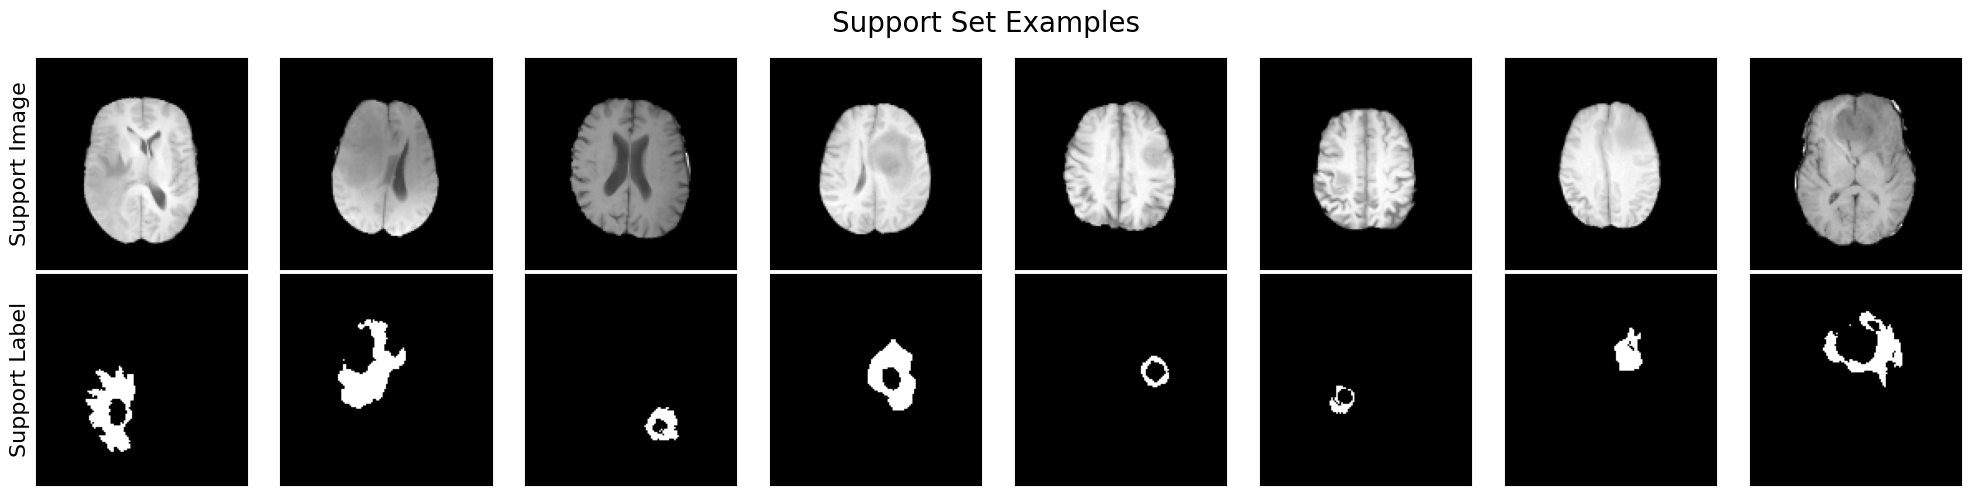

In [30]:
n_viz = 8
visualize_tensors({
    'Support Image': support_images[:n_viz],
    'Support Label': support_labels[:n_viz],
}, col_wrap=8, title='Support Set Examples')

  0%|          | 0/10 [00:00<?, ?it/s]

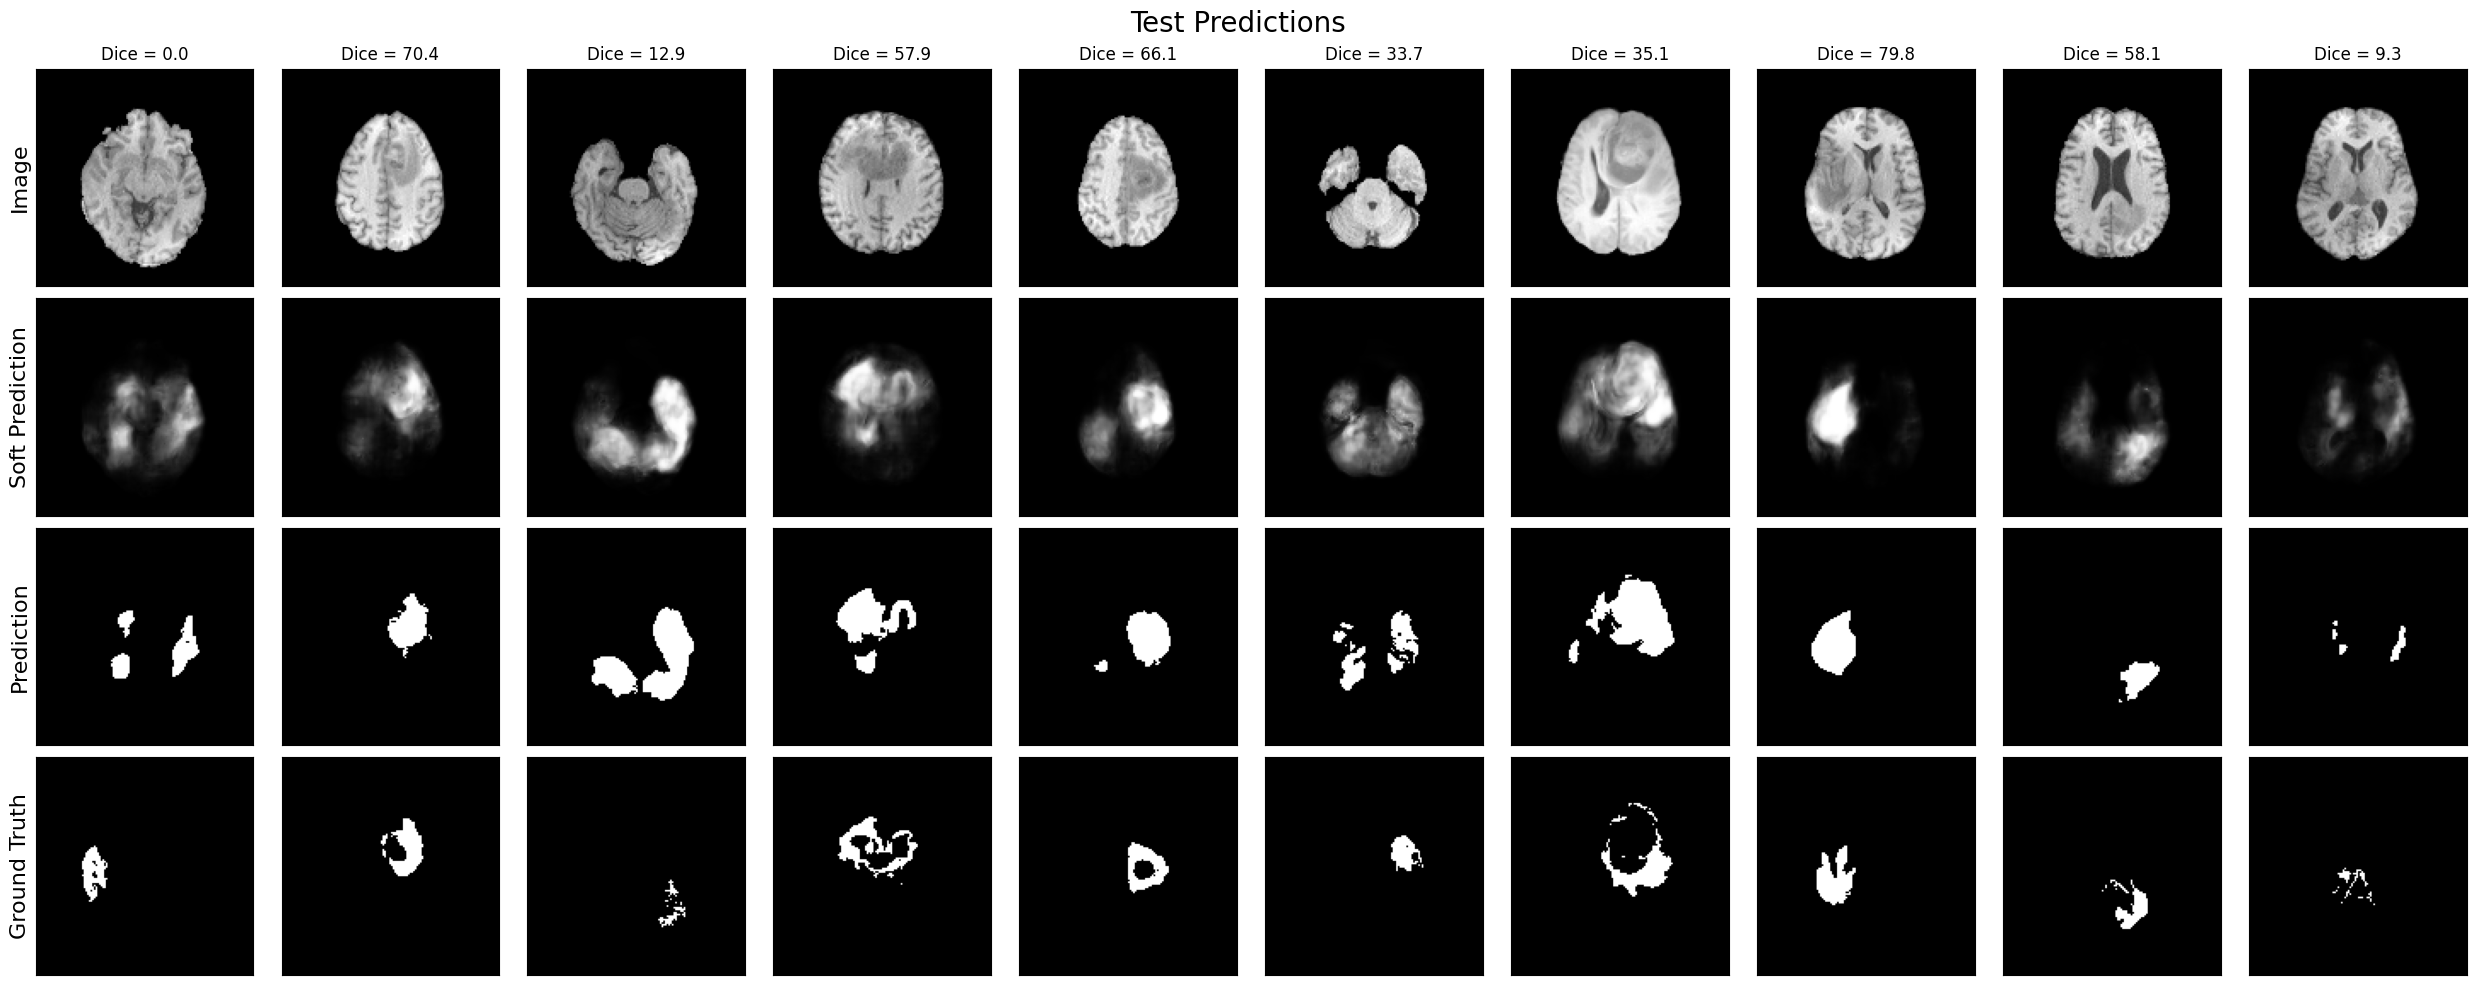

In [31]:
from collections import defaultdict

n_predictions = 10

results = defaultdict(list)

# compute inference and save predictions and metrics for n_predictions
idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in tqdm(idxs):
    image, label = d_test[i]
    vals = inference(model, image, label, support_images, support_labels)
    for k, v in vals.items():
        results[k].append(v)


# visualize the results, along with their scores
scores = results.pop('score')
visualize_tensors(results,
                  col_names=[f'Dice = {100*s:.1f}' for s in scores],
                  title='Test Predictions',
                  col_wrap=n_predictions)

## Universeg Inference on NSCLC

Tumor segmentation in lung CT

In [32]:
n_support = 64

dataset_root = '/content/drive/MyDrive/Tutorials/NSCLC'
d_support = UniverSegDataloader(split='support', data_root=dataset_root, n_support=n_support)
d_test = UniverSegDataloader(split='test', data_root=dataset_root, n_support=n_support)

print(len(d_test))

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

80


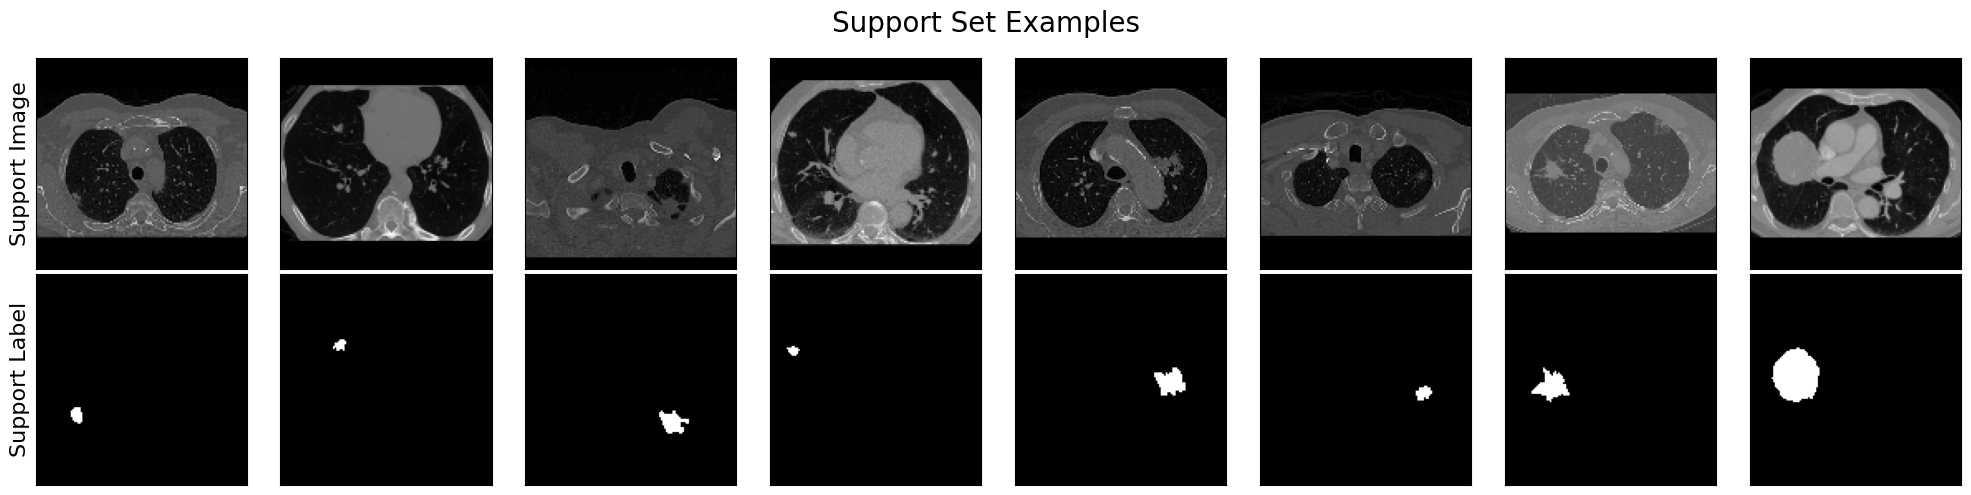

In [33]:
n_viz = 8
visualize_tensors({
    'Support Image': support_images[:n_viz],
    'Support Label': support_labels[:n_viz],
}, col_wrap=8, title='Support Set Examples')

  0%|          | 0/10 [00:00<?, ?it/s]

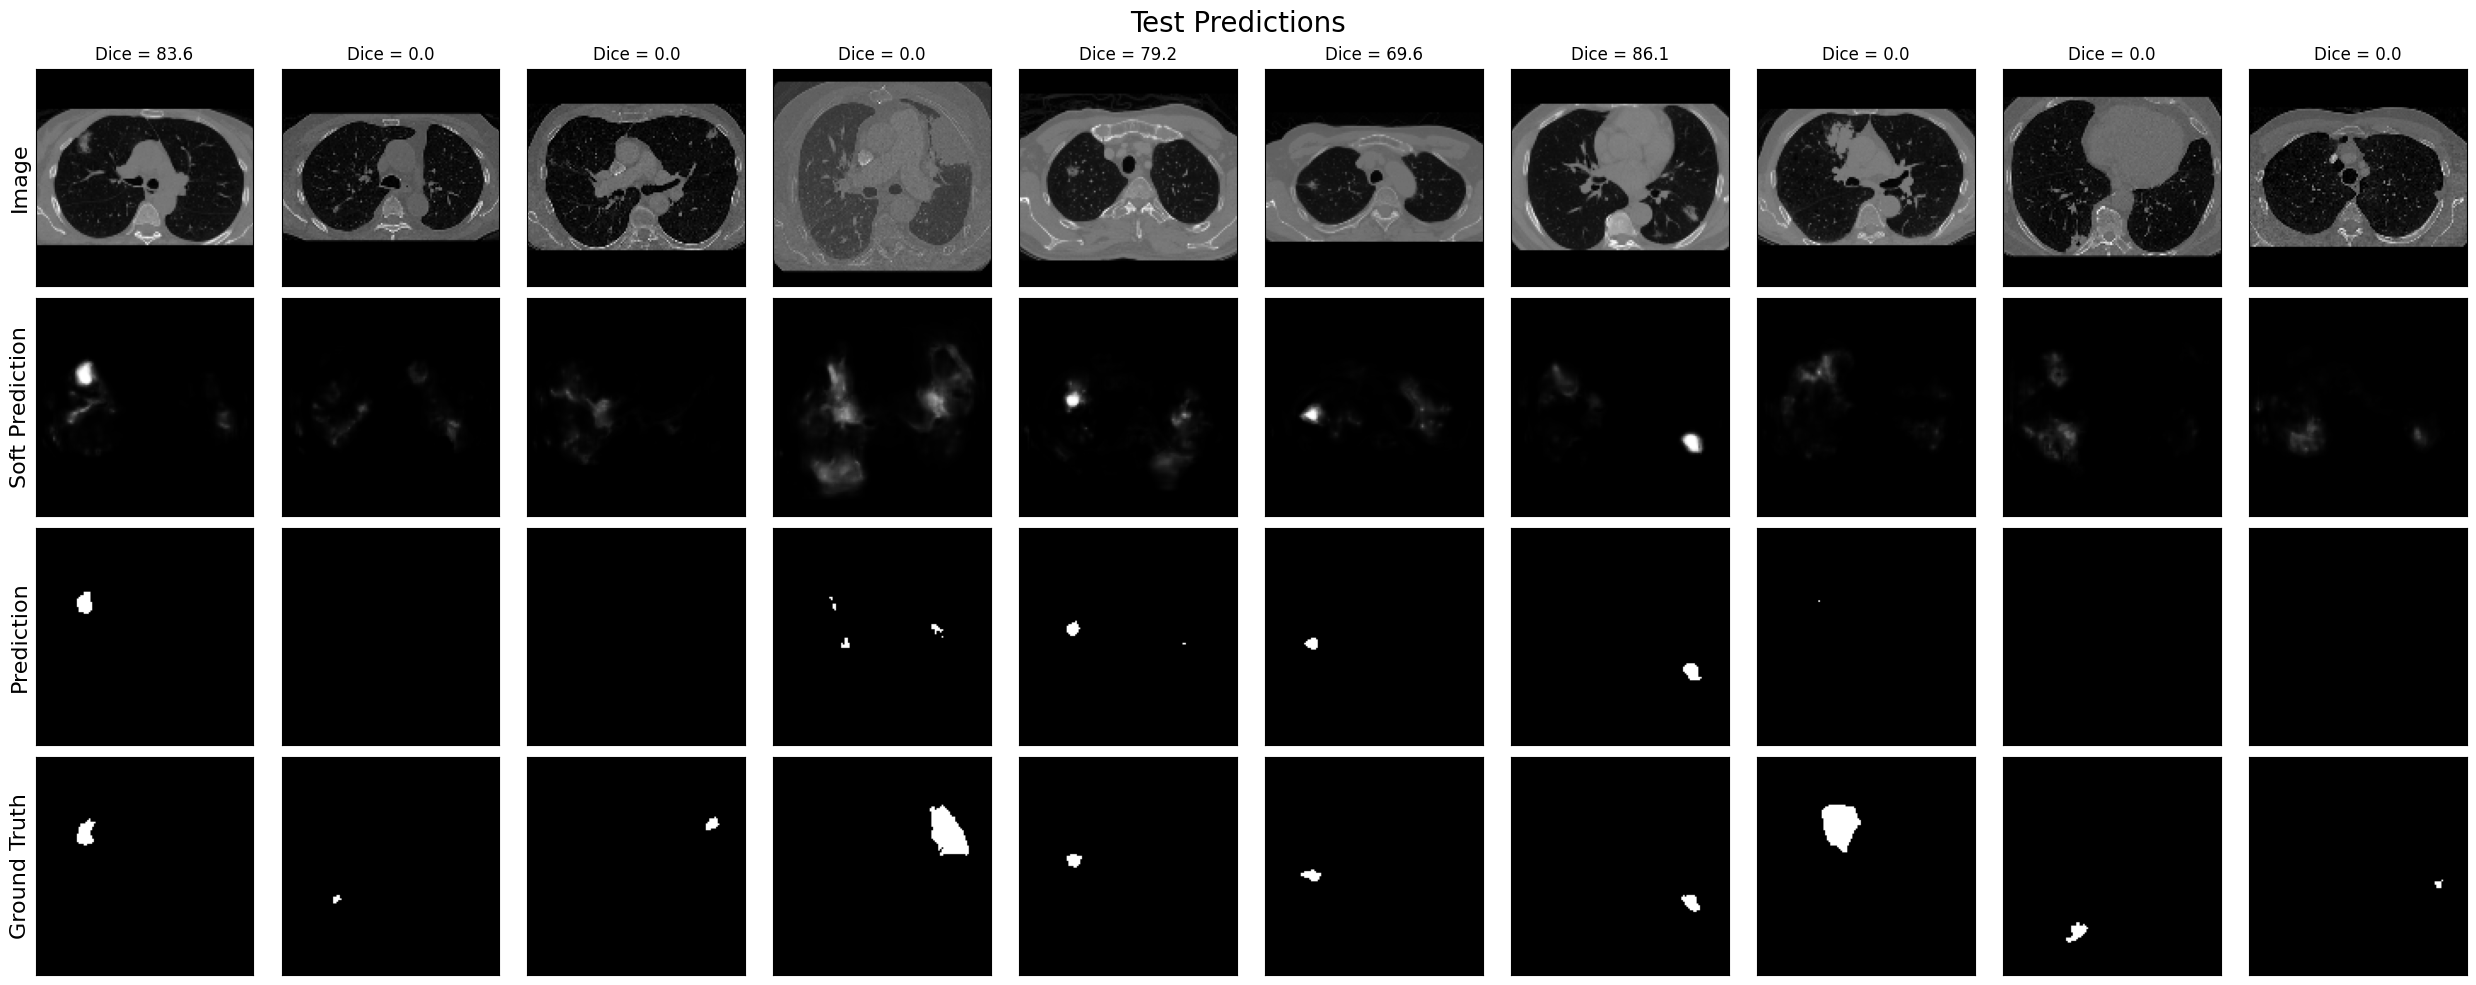

In [34]:
from collections import defaultdict

n_predictions = 10

results = defaultdict(list)

# compute inference and save predictions and metrics for n_predictions
idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in tqdm(idxs):
    image, label = d_test[i]
    vals = inference(model, image, label, support_images, support_labels)
    for k, v in vals.items():
        results[k].append(v)

# visualize the results, along with their scores
scores = results.pop('score')
visualize_tensors(results,
                  col_names=[f'Dice = {100*s:.1f}' for s in scores],
                  title='Test Predictions',
                  col_wrap=n_predictions)

## Universeg Inference on Sarcomas

Tumor segmentation in extremities MRI

In [35]:
n_support = 32

dataset_root = '/content/drive/MyDrive/Tutorials/Sarcoma'
d_support = UniverSegDataloader(split='support', data_root=dataset_root, n_support=n_support)
d_test = UniverSegDataloader(split='test', data_root=dataset_root, n_support=n_support)

print(len(d_test))

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

19


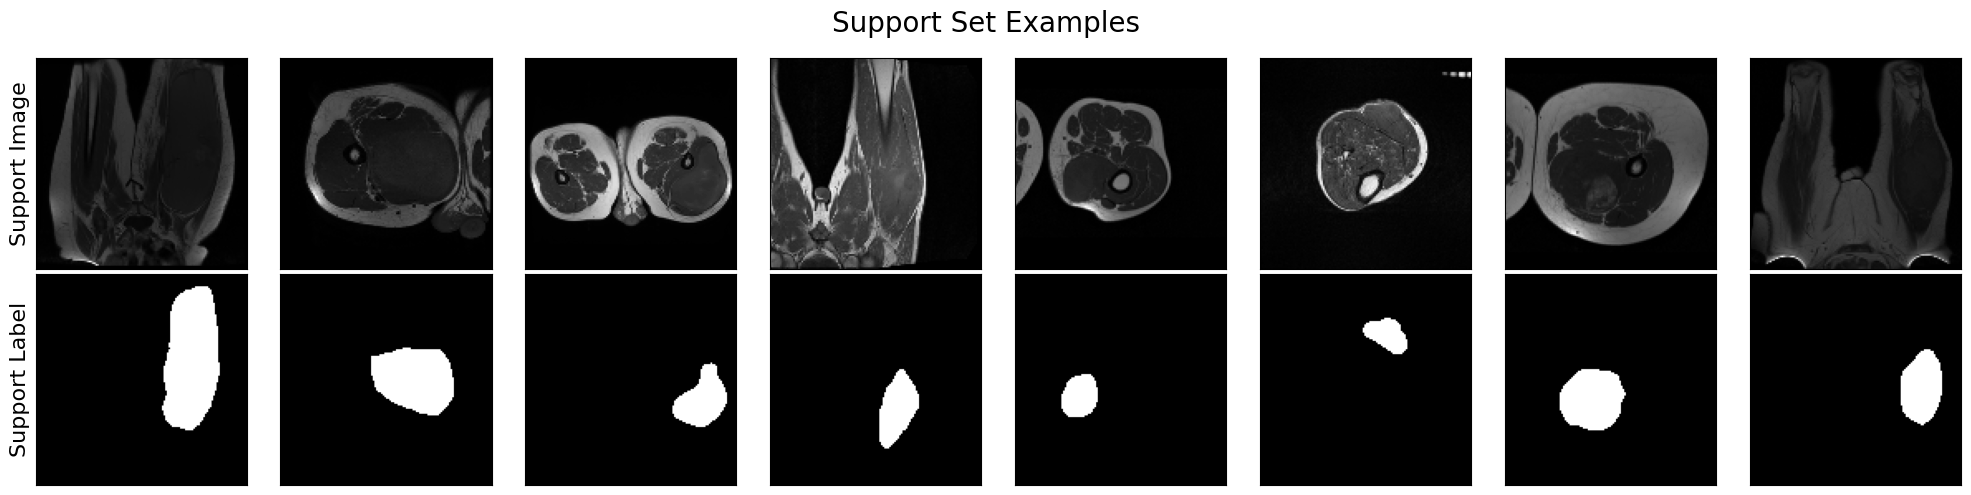

In [36]:
n_viz = 8
visualize_tensors({
    'Support Image': support_images[:n_viz],
    'Support Label': support_labels[:n_viz],
}, col_wrap=8, title='Support Set Examples')

  0%|          | 0/10 [00:00<?, ?it/s]

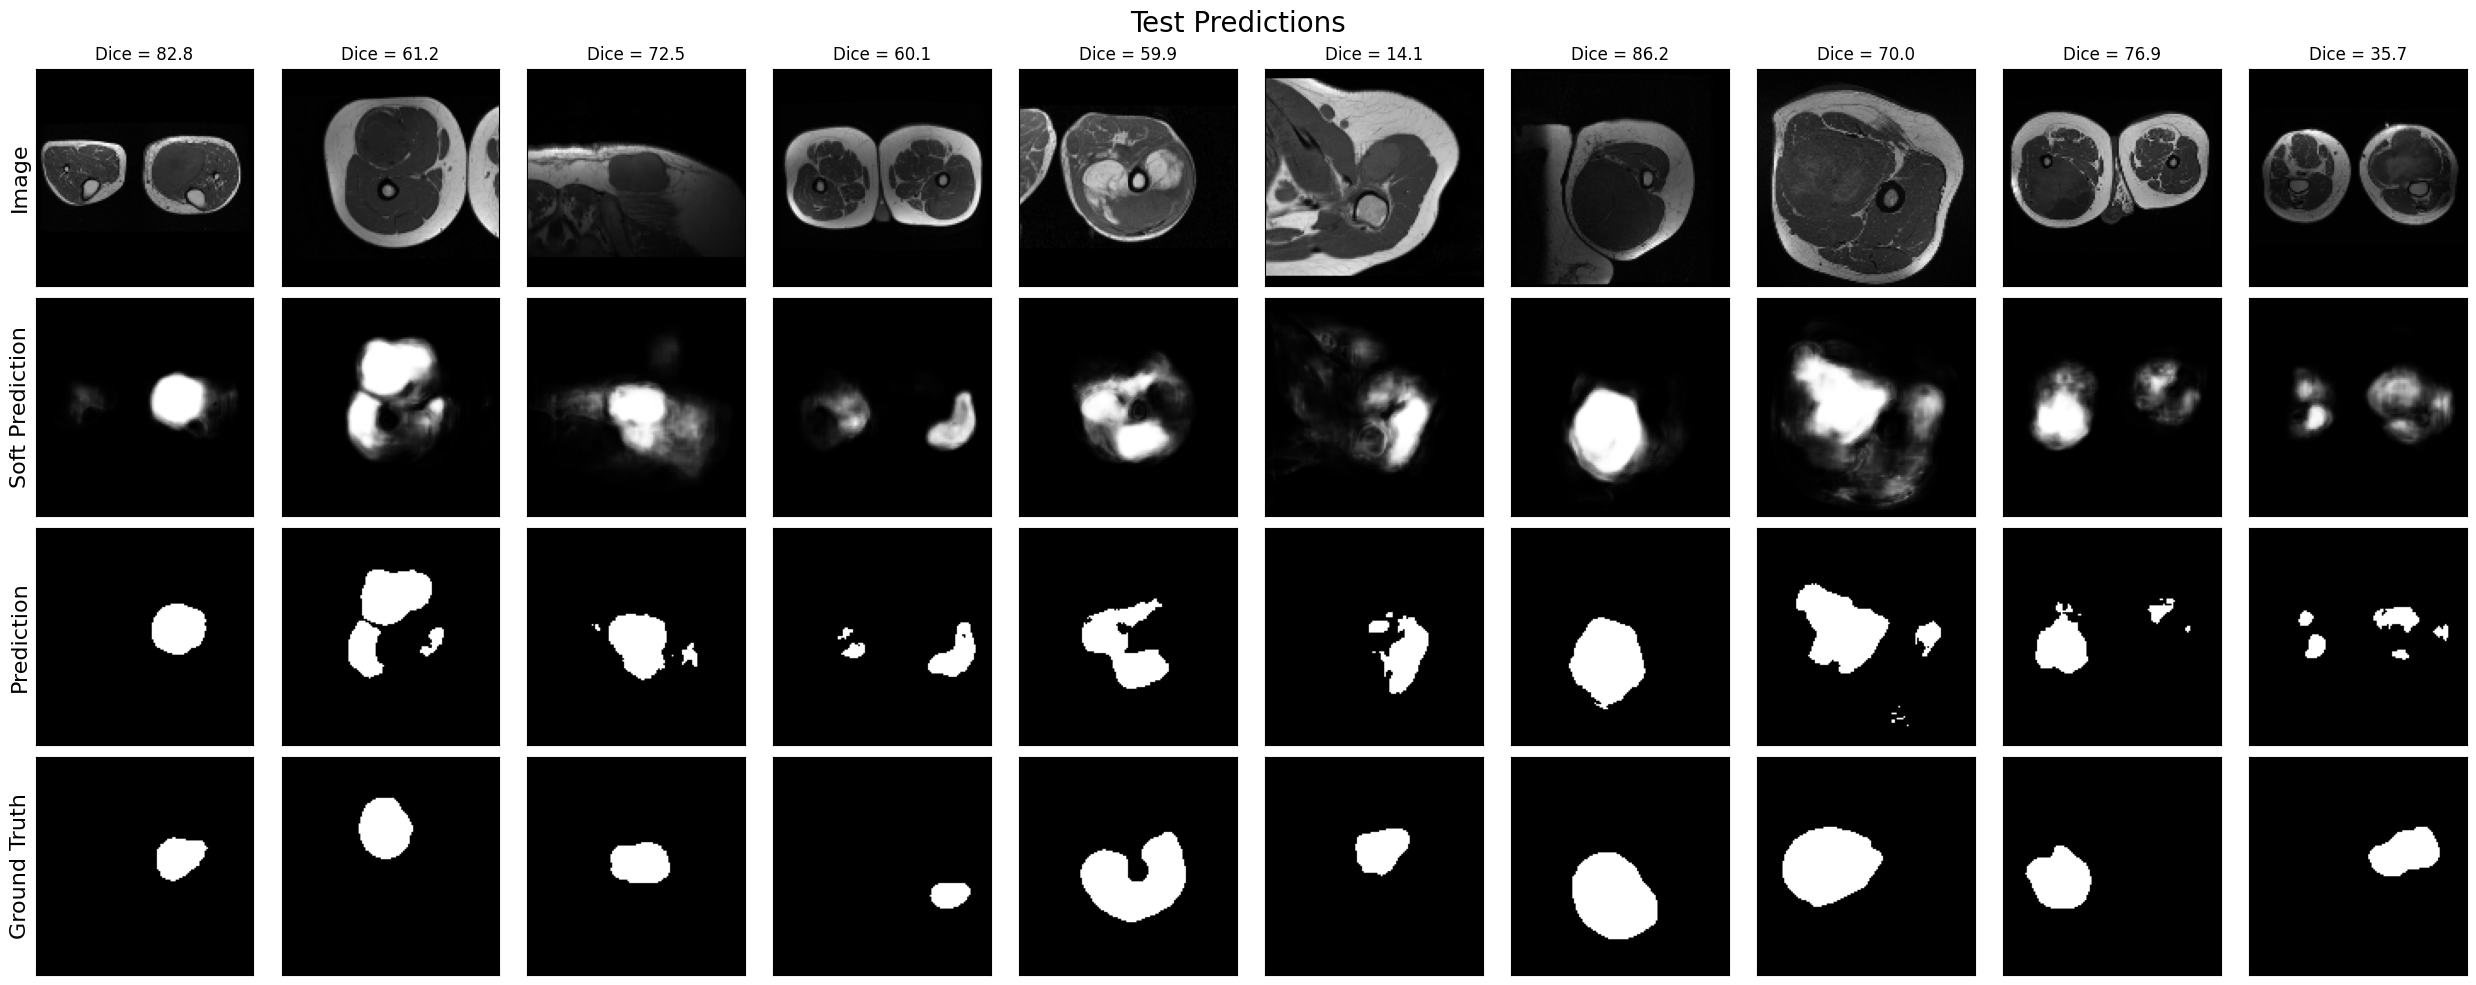

In [37]:
from collections import defaultdict

n_predictions = 10

results = defaultdict(list)

# compute inference and save predictions and metrics for n_predictions
idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in tqdm(idxs):
    image, label = d_test[i]
    vals = inference(model, image, label, support_images, support_labels)
    for k, v in vals.items():
        results[k].append(v)

# visualize the results, along with their scores
scores = results.pop('score')
visualize_tensors(results,
                  col_names=[f'Dice = {100*s:.1f}' for s in scores],
                  title='Test Predictions',
                  col_wrap=n_predictions)


## Effect of the Support Set Size: Sarcomas

Here we study how changing the number of support examples affects the prediction, and find that increasing the support set size leads to improved results

In [38]:
n_support = 32
dataset_root = '/content/drive/MyDrive/Tutorials/Sarcoma'
d_support = UniverSegDataloader(split='support', data_root=dataset_root, n_support=n_support)
d_test = UniverSegDataloader(split='test', data_root=dataset_root, n_support=n_support)


support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

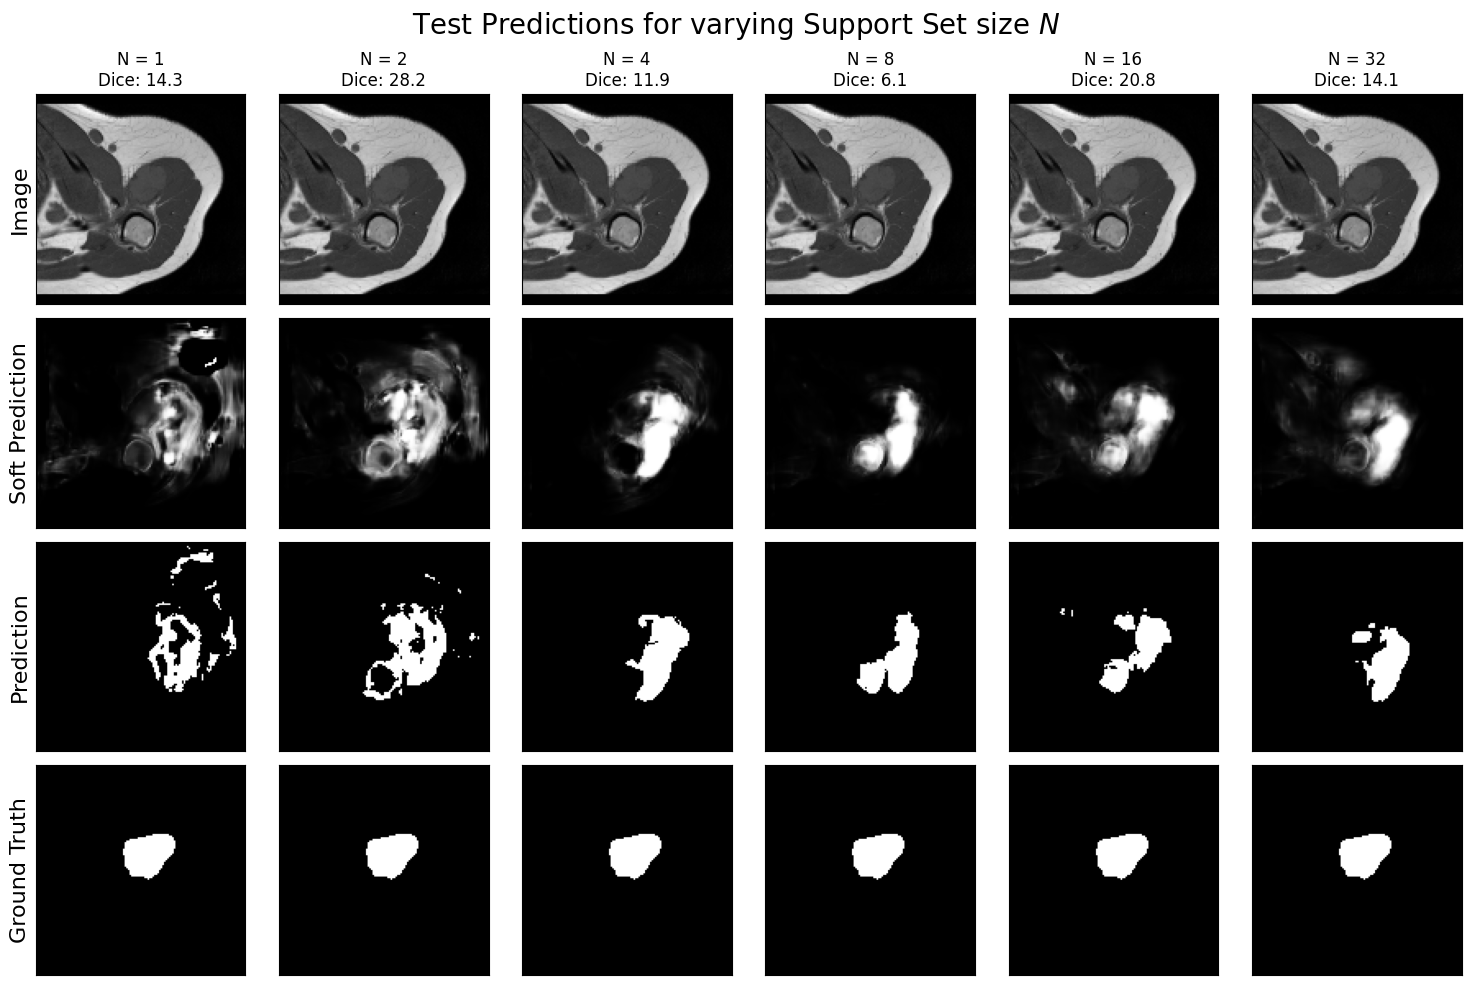

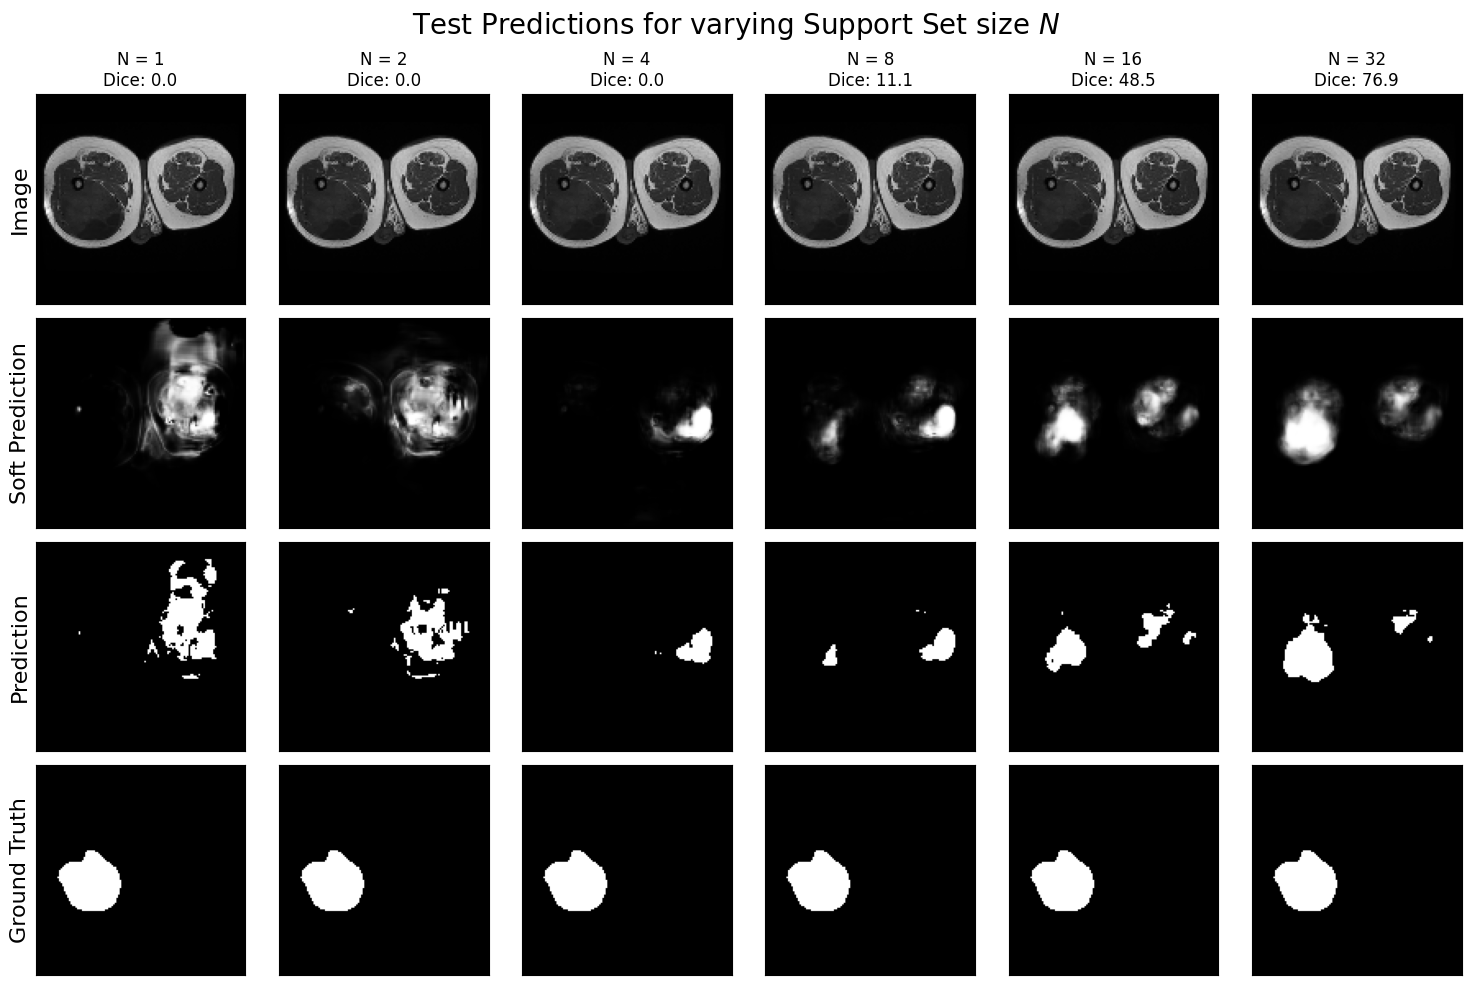

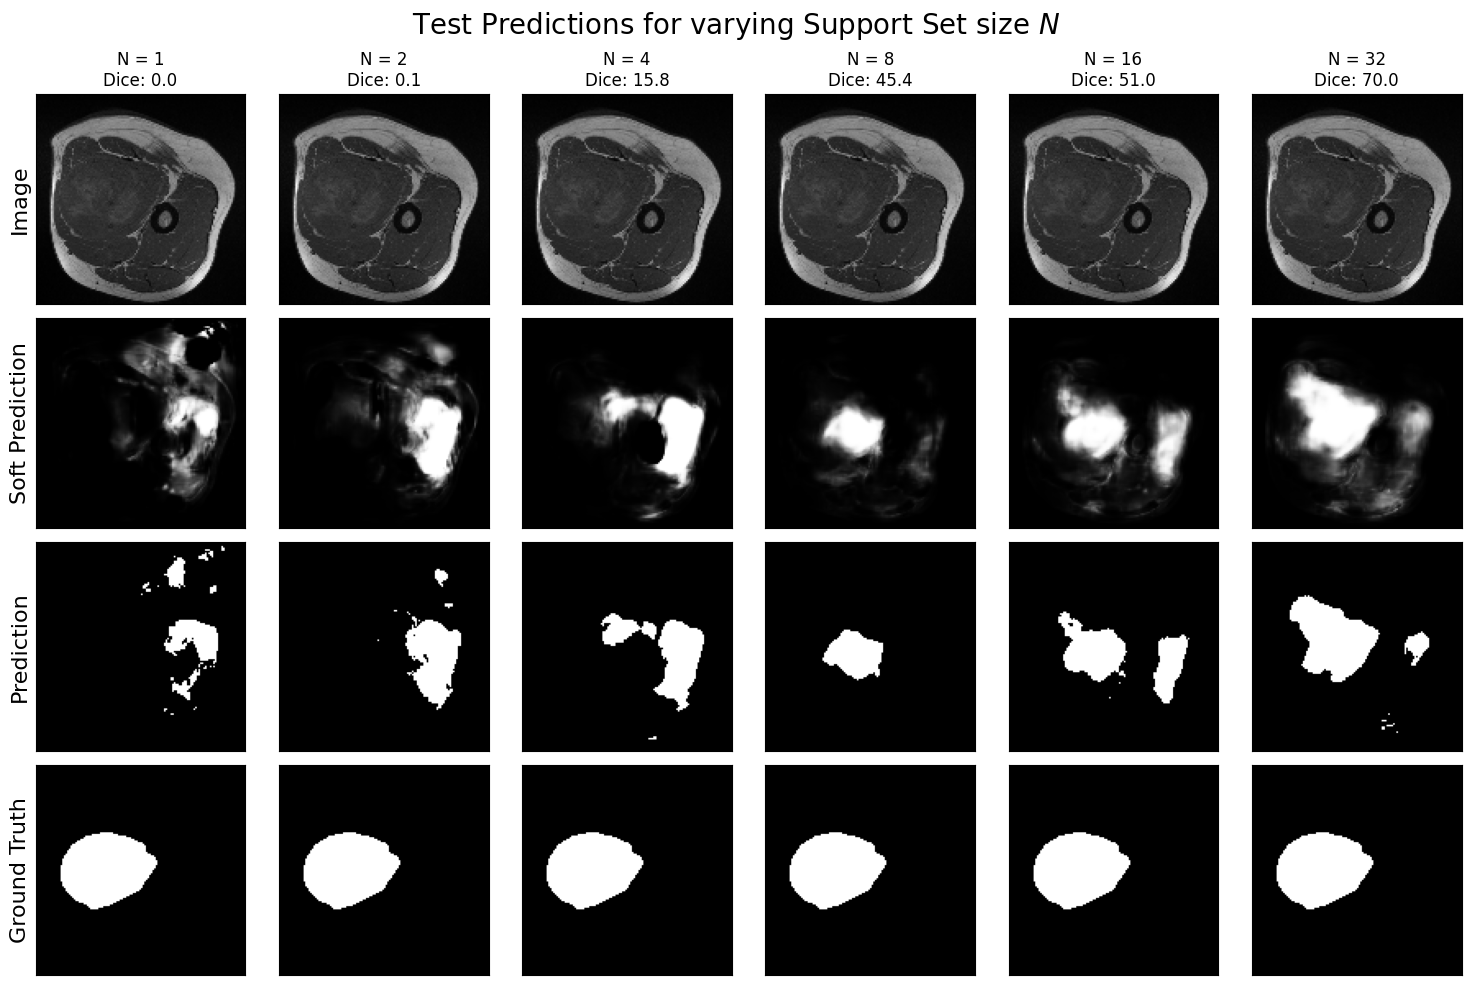

In [39]:
n_predictions = 3
support_set_sizes = [1, 2, 4, 8, 16, 32]

idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in idxs:
    results = defaultdict(list)
    for N in support_set_sizes:
        image, label = d_test[i]
        vals = inference(model, image, label, support_images[:N], support_labels[:N])
        for k, v in vals.items():
            results[k].append(v)

    # visualize for this entry for different support sizes
    scores = results.pop('score')
    col_names = [f'N = {N}' for N in support_set_sizes]
    col_names = [col+f'\nDice: {100*score:.1f}' for col, score in zip(col_names, scores)]
    visualize_tensors(results, col_names=col_names, title='Test Predictions for varying Support Set size $N$', col_wrap=len(support_set_sizes))


## 7. Ensembling Predictions: Sarcoma

Different support sets lead to different prediction segmentations.  
In this section we show that ensembling predictions can lead to improved results, especially for smaller support sets used in each prediction.  
We analyze this in more detail in the [paper](https://arxiv.org/abs/2304.06131).

In [40]:
# helpful function to sample support data
def sample_support(seed):
    rng = np.random.default_rng(seed)
    idxs = rng.integers(0,len(d_support), size=support_size)
    support_images, support_labels = zip(*[d_support[i] for i in idxs])
    support_images = torch.stack(support_images).to(device)
    support_labels = torch.stack(support_labels).to(device)
    return support_images, support_labels

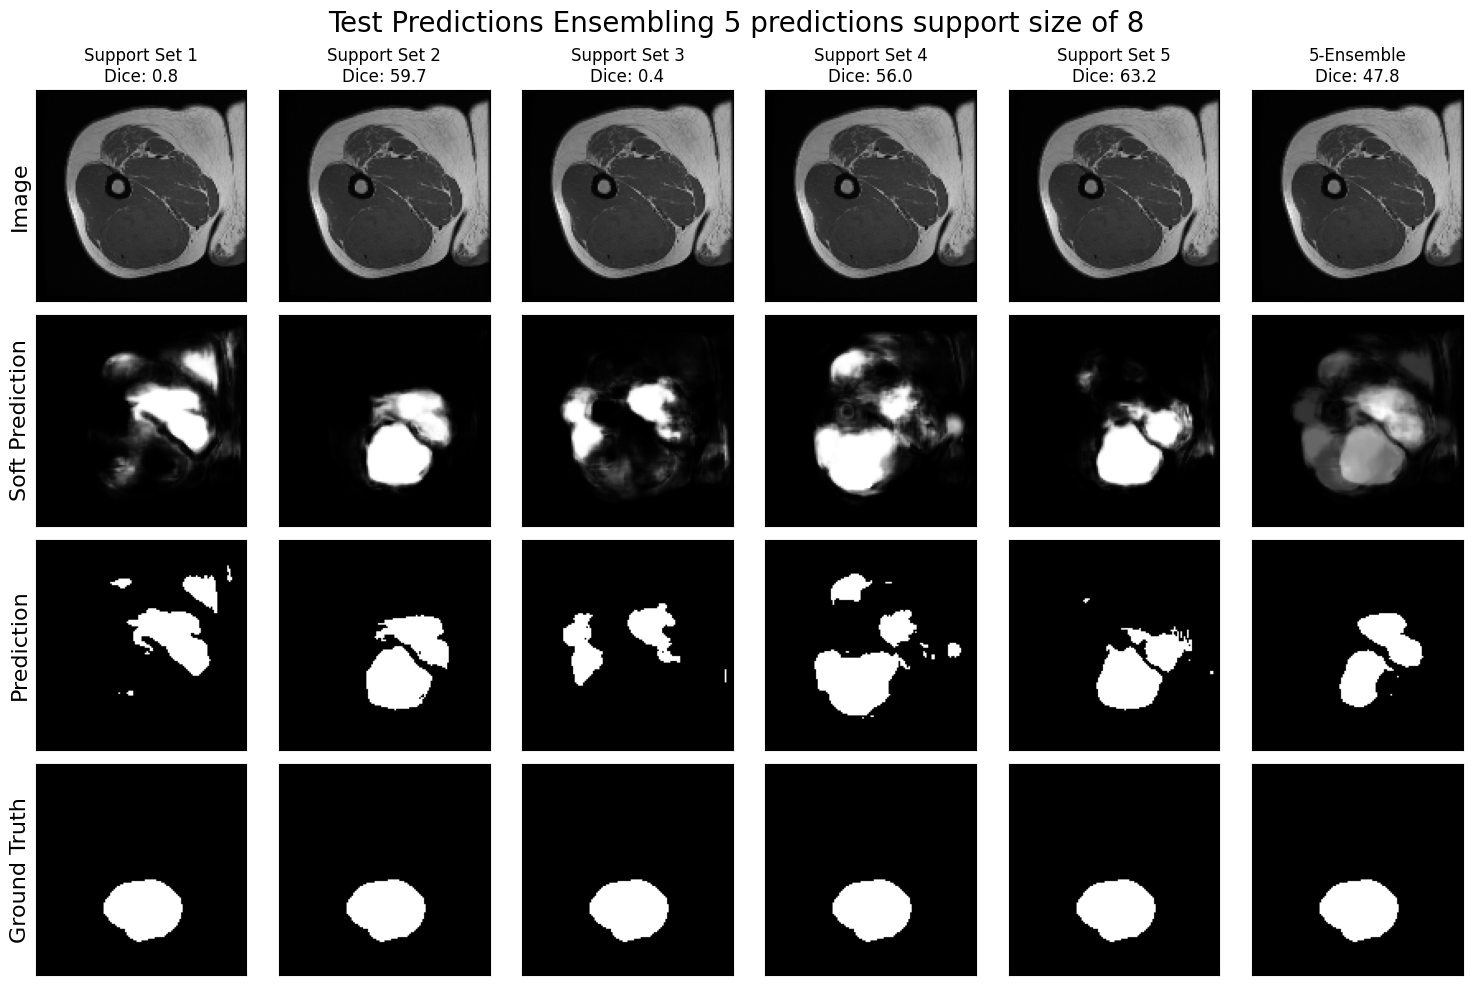

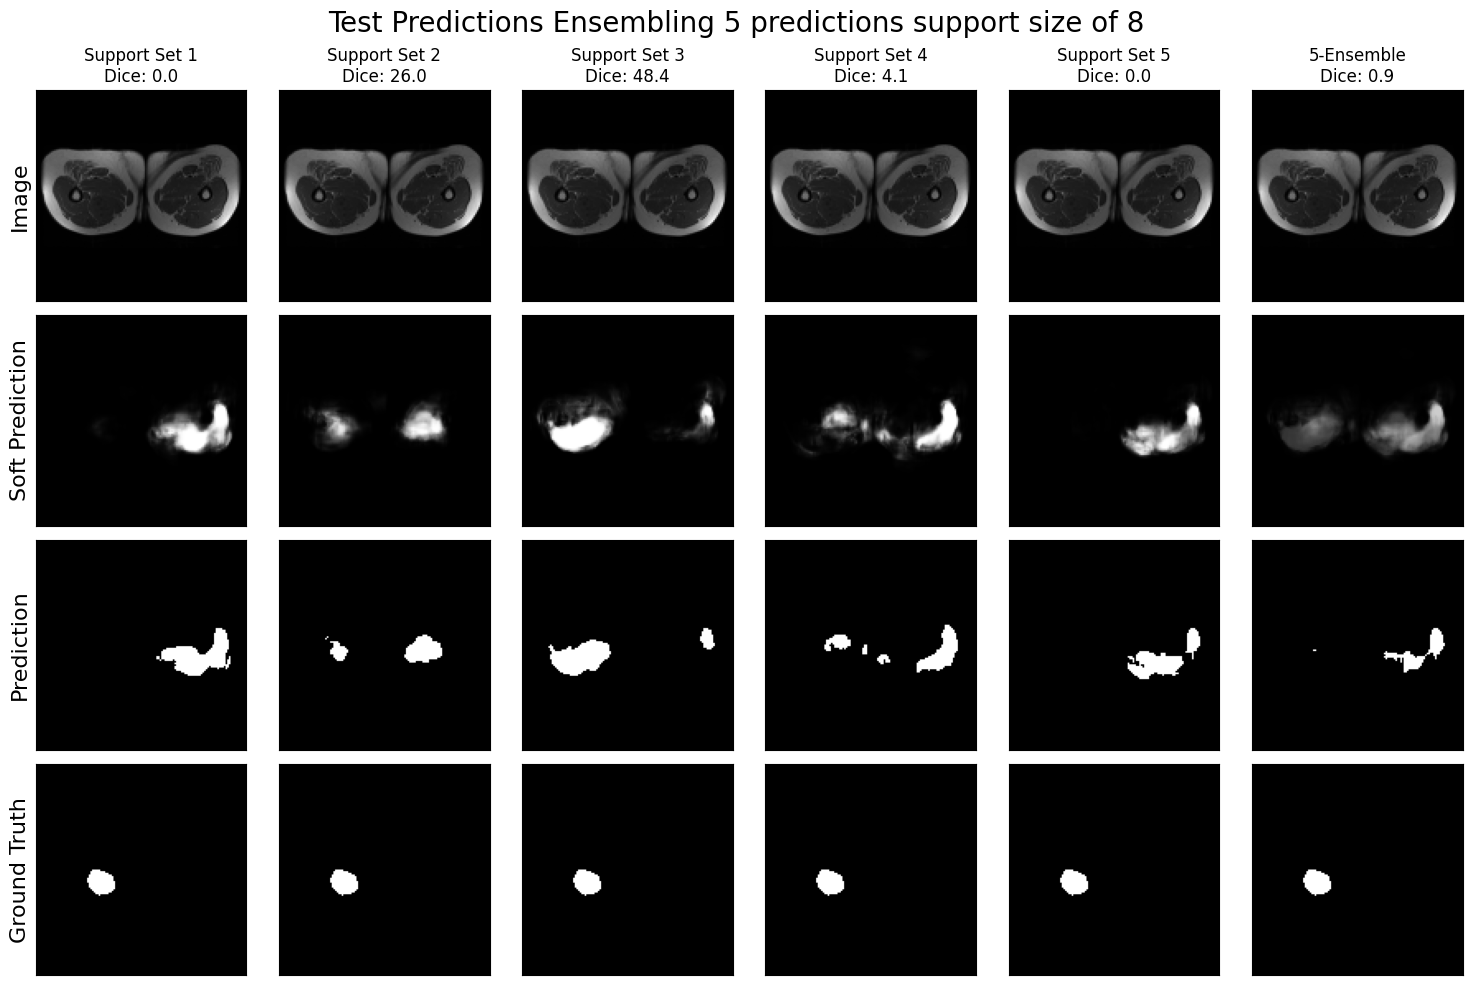

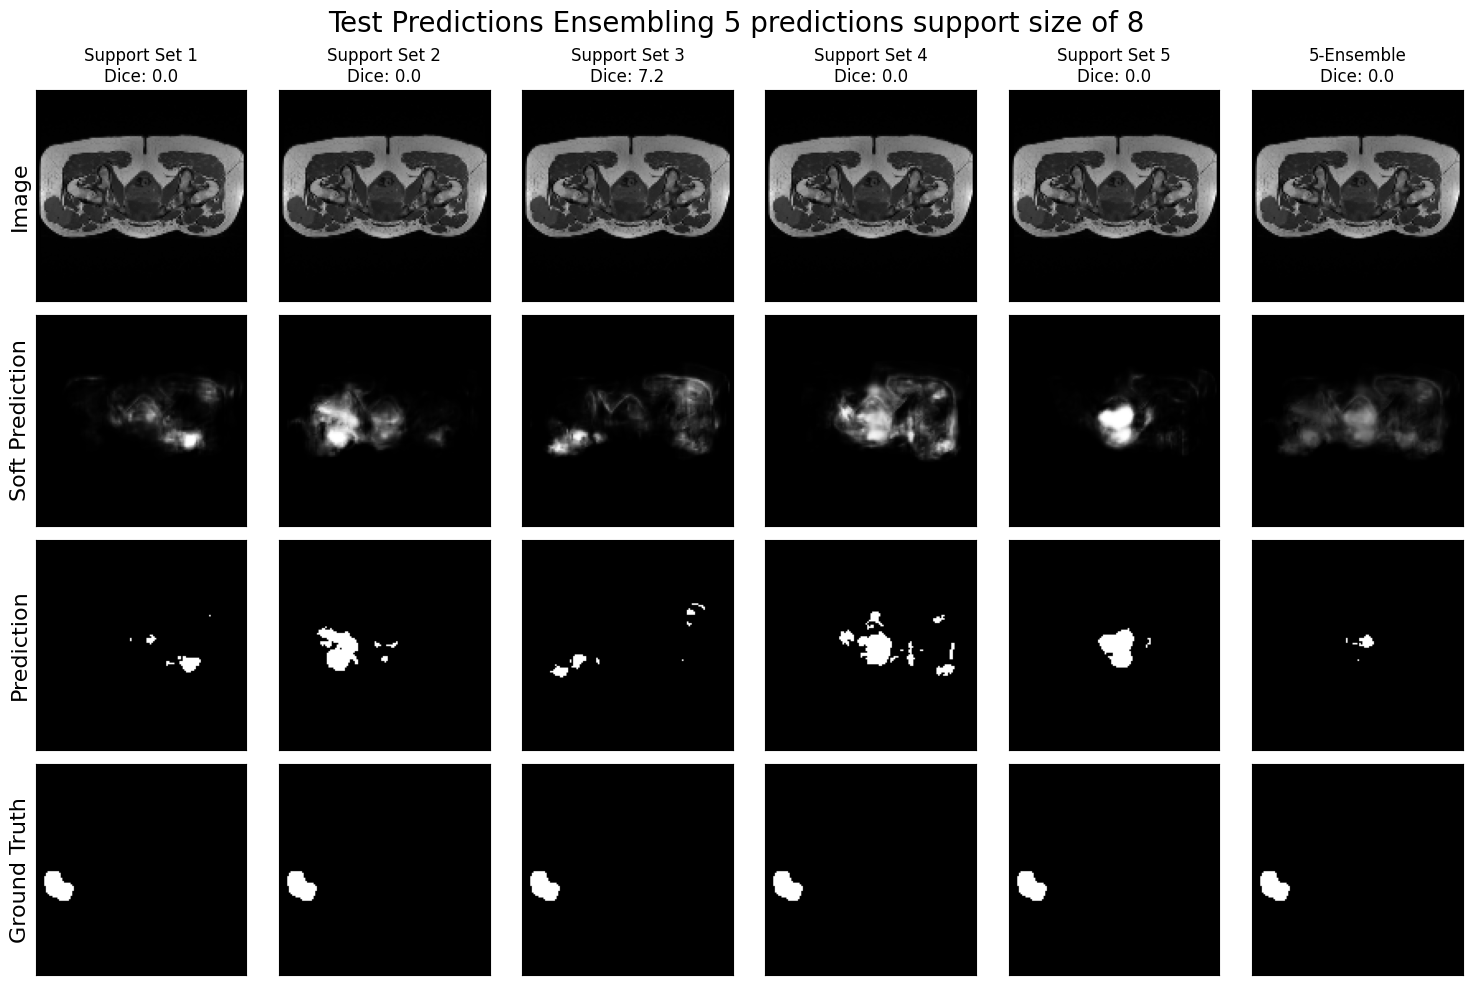

In [41]:

# setup the number of predictions and ensembling
support_size = 8
n_predictions = 3
n_ensemble = 5

dataset_root = '/content/drive/MyDrive/Tutorials/Sarcoma'
d_support = UniverSegDataloader(split='support', data_root=dataset_root, n_support=n_support)
d_test = UniverSegDataloader(split='test', data_root=dataset_root, n_support=n_support)

# get various support sets
idxs = np.random.permutation(len(d_test))[:n_predictions]
seeds = range(n_ensemble)
supports = {
    seed: sample_support(seed)
    for seed in range(n_ensemble)
}

# go through the number of experiments
for i in idxs:

    # go through the number of predictions we will ensemble
    results = defaultdict(list)
    for j in range(n_ensemble):
        # get support set and query
        support_images, support_labels = sample_support(j)
        image, label = d_test[i]

        # perform inference
        vals = inference(model, image, label, support_images, support_labels)
        for k, v in vals.items():
            results[k].append(v)

    results['Image'].append(image)
    ensemble = torch.mean(torch.stack(results['Soft Prediction']), dim=0)
    results['Soft Prediction'].append(ensemble)
    results['Prediction'].append(ensemble.round())
    results['Ground Truth'].append(label)
    results['score'].append(dice_score(ensemble.round(), label.to(device)))

    scores = results.pop('score')
    col_names = [f'Support Set {i+1}' for i in range(n_ensemble)] + [f'{n_ensemble}-Ensemble']
    col_names = [col+f'\nDice: {100*score:.1f}' for col, score in zip(col_names, scores)]

    visualize_tensors(results,
                      col_names=col_names,
                      title=f'Test Predictions Ensembling {n_ensemble} predictions support size of {support_size}',
                      col_wrap=n_ensemble+1)